# Nets vs Derms - Tensorflow Notebook
 - select a test/val set for inference - set of filenames
 - convert filenames into tensors
 - load up a checkpoint using a session
 - feedforward tensors, collecting probs
 - Analyze accuracies, ROC curves, etc. 
 
### TODO
 - probabilities are extracted, now keep the relevant ones and plot the SS curve
 - document the hell out of the mess of functions below
 - add them to some general io.py file somewhere

In [2]:
import sys
# sys.path.append('/media/esteva/ExtraDrive1/ThrunResearch/tensorflow_master/models/inception')
import inception
from inception import image_processing
from inception import inception_model

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import average_precision_score, roc_curve, auc

import libtf
from libtf.learning import vis_utils as vu
from libtf.learning import clumping_utils as cu

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def readfile(filename):
    return [line.strip() for line in open(filename).readlines()]


def binary_01(l):
    """Converts 3,4 and 7,8 into 0,1"""
    if l == 7: return 0
    if l == 8: return 1
    if l == 3: return 0
    if l == 4: return 1
    if l == 0: return 0
    if l == 1: return 1


def label(entry):
    """Returns the label as a 0 or 1."""
    if isinstance(entry, list):
        return [label(ll) for ll in entry]
    l = int(entry.split()[1])
    return binary_01(l)


def path(entry):
    if isinstance(entry, list):
        return [path(e) for e in entry]
    return entry.split()[0]

def image_preprocess(path):
    """Convert path tensor into inception-network-ready 4D tensor"""
    image_string = tf.read_file(path)
    # TODO: dynamically decide on png or jpeg, or convert all to one or the other
#     im = tf.image.decode_png(image_string, channels=3)
    im = tf.image.decode_jpeg(image_string, channels=3)
    im = tf.image.convert_image_dtype(im, dtype=tf.float32)

    im = tf.image.central_crop(im, central_fraction=0.875)
    im = tf.expand_dims(im, 0)
    im = tf.image.resize_bilinear(im, [299, 299], align_corners=False)
    im = tf.sub(im, 0.5)
    im = tf.mul(im, 2.0)
       
    im = tf.cast(im, tf.float32)
    im = tf.reshape(im, shape=[1, 299, 299, 3])
    
    return im


def data_reader(data_filename):
    record_defaults = [['/a/path'], [0]]
    filename_queue = tf.train.string_input_producer([data_filename])
    reader = tf.TextLineReader()
    key, value = reader.read(filename_queue)
    path, label = tf.decode_csv(value, record_defaults, field_delim=" ")
    return path, label


def restore_model(checkpoint_dir, sess): 
    variable_averages = tf.train.ExponentialMovingAverage(
        inception_model.MOVING_AVERAGE_DECAY)
    variables_to_restore = variable_averages.variables_to_restore()
    saver = tf.train.Saver(variables_to_restore)
    
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        if os.path.isabs(ckpt.model_checkpoint_path):
            # Restores from checkpoint with absolute path.
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            # Restores from checkpoint with relative path.
            saver.restore(sess, os.path.join(checkpoint_dir,
                                             ckpt.model_checkpoint_path))

        # Assuming model_checkpoint_path looks something like:
        #   /my-favorite-path/imagenet_train/model.ckpt-0,
        # extract global_step from it.
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        print('Succesfully loaded model from %s at step=%s.' %
            (ckpt.model_checkpoint_path, global_step))
    else:
        print('No checkpoint file found')
        
def extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes):
    probabilities = []
    num_entries = len(readfile(data_filename))
    with tf.Graph().as_default(), tf.Session() as sess:
        # Relevant Ops
        path, label = data_reader(data_filename)
        image = image_preprocess(path)
        logits, _ = inception_model.inference(image, num_classes)
        softmax = tf.nn.softmax(logits)

        # Load checkpoint
        restore_model(checkpoint_dir, sess)    

        # Start populating the filename queue.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(num_entries):            
            # Retrieve a single instance:
            p, l = sess.run([path, label])
            print '\rExtracting %d / %d, %s' % (i+1, num_entries, p),
#             i, p, l = sess.run([image, path, label])  
            sm = sess.run([softmax])[0]
            probabilities.append(sm)

        coord.request_stop()
        coord.join(threads)
    probabilities = np.vstack(probabilities)
#     probabilities = probablities[:, 1:] # eliminate unused background class
    return probabilities

def keep_pigmented_probabilities(probs):
    p = probs[:, 7:]
    p /= np.sum(p, axis=1).reshape((-1,1))
    return p


def keep_epidermal_probabilities(probs):
    p = probs[:, 3:5]
    p /= np.sum(p, axis=1).reshape((-1,1))
    return p


def keep_malignantbenign_probabilities(probs):
    """Returns a two column array of benign and malignant probabilities. Sums probabilities from the 4 classes."""
    p0 = np.hstack((probs[:, 3].reshape((-1,1)), probs[:, 7].reshape((-1,1))))
    p0 = np.sum(p0, axis=1)
    p1 = np.hstack((probs[:, 4].reshape((-1,1)), probs[:, 8].reshape((-1,1))))
    p1 = np.sum(p1, axis=1)
    p = np.hstack((p0.reshape((-1,1)), p1.reshape((-1,1))))
    p /= np.sum(p, axis=1).reshape((-1,1))
    return p


def plot_results(data, probs, people, title, show_legend=False, return_fig_handle=False, textcolor='#4D5B66'):
    """Plots the SS and prints best results for the data, given the extracted probs."""

    fpr, tpr, thresholds = roc_curve(label(data), probs)
    tnr = 1 - fpr
    ss = np.concatenate((tpr.reshape((-1,1)), tnr.reshape((-1,1)), thresholds.reshape((-1,1))), axis=1)
    best = np.argmax(np.mean(ss[:, :2], axis=1))
    best_sens = ss[best, 0]
    best_spec = ss[best, 1]
    best_thresh = ss[best, 2]
    auc_ss = auc(fpr, tpr)

    print 'Best sens', best_sens
    print 'Best spec', best_spec
    print 'Best thresh', best_thresh
    fig, ax = vu.plotSSCurve(tpr, tnr, people=people, title=title, show_legend=show_legend, textcolor=textcolor)
    if return_fig_handle:
        return fig, ax
    
    
def probs_malignant(probs):
    """Return the malignant column (always column 1)"""
    assert probs.shape[1] == 2
    return probs[:, 1]


# Nine-way net

In [69]:
data_filename = '/media/esteva/ExtraDrive1/ThrunResearch/web/image_classifier/curated_edinburgh/epidermal_test.txt'
data = readfile(data_filename)

checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/train'
num_classes = 9 + 1 # background class is 0

probabilities = extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes)
# probabilities = keep_epidermal_probabilities(probabilities)
print probabilities.shape
print np.argmax(probabilities, axis=1)

Succesfully loaded model from model.ckpt-85000 at step=85000.
Extracting 135 / 135, /media/esteva/ExtraDrive1/ThrunResearch/data/edinburgh/test_sets/epidermal/4/SCC/P246/P246.png (135, 10)
[4 4 4 4 4 4 4 4 9 4 4 4 4 4 4 5 4 4 4 5 5 8 5 8 4 4 4 4 4 5 4 4 4 4 4 5 5
 5 4 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 4 4 5 8 5 4
 4 4 4 4 4 4 4 4 4 4 8 5 8 4 5 5 4 4 8 4 4 4 4 4 8 4 4 4 4 5 5 5 5 5 5 5 5
 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.525925925926
Best sens 0.523076923077
Best spec 0.671428571429
Best thresh 0.636168658733
The AUC is 0.532087912088


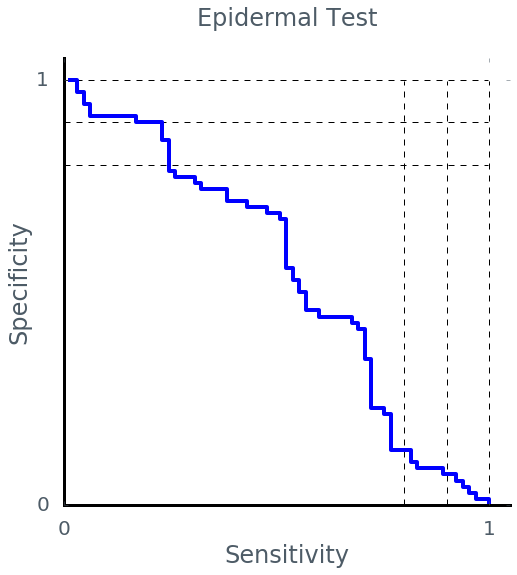

In [70]:
p = probabilities.copy()
p = p[:, 4:6]
p /= np.sum(p, axis=1).reshape((-1,1))
p = np.argmax(p, axis=1)
print p

l = np.array(label(data))
print l

print 1.0 * np.sum(p == l) / len(l)

plot_results(data, probs_malignant(probabilities[:, 4:6]), [], 'Epidermal Test')

In [5]:
data_filename = '/media/esteva/ExtraDrive1/ThrunResearch/web/image_classifier/curated_pigmented/dermtest_144_noepic.txt'
data = readfile(data_filename)

checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/nine-way/train'
num_classes = 9 + 1 # background class is 0

probabilities = extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes)
# probabilities = keep_epidermal_probabilities(probabilities)
print probabilities.shape

Succesfully loaded model from model.ckpt-85000 at step=85000.
Extracting 130 / 130 (130, 10)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.746153846154
Best sens 0.515151515152
Best spec 0.721649484536
Best thresh 0.142459079623
The AUC is 0.612464854733


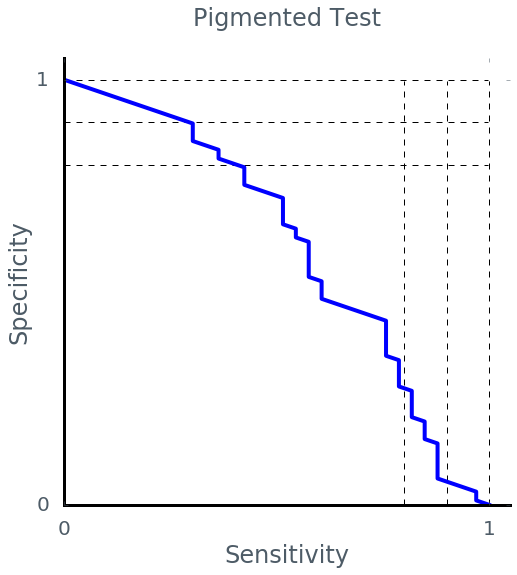

In [9]:
p = probabilities.copy()
p = p[:, 8:10]
p /= np.sum(p, axis=1).reshape((-1,1))
p = np.argmax(p, axis=1)
print p

l = np.array(label(data))
print l

print 1.0 * np.sum(p == l) / len(l)

plot_results(data, probs_malignant(probabilities[:, 8:10]), [], 'Pigmented Test')

# RD-1000

In [17]:
data_filename = '/media/esteva/ExtraDrive1/ThrunResearch/web/image_classifier/curated_edinburgh/epidermal_test.txt'
data = readfile(data_filename)

checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train'
mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mapping'

mapping = ['__unused_background_class__ __unused_background_class']
_mapping = readfile(mapping_file)
mapping.extend(_mapping)

num_classes = 759 + 1 # background class is 0

probabilities = extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes)
# probabilities = keep_epidermal_probabilities(probabilities)
print probabilities.shape
print np.argmax(probabilities, axis=1)

probs = probabilities.copy()
probs = cu.mergeProbabilities(probs, mapping)

print probs.shape
print np.argmax(probs, axis=1)

Succesfully loaded model from model.ckpt-110000 at step=110000.
Extracting 135 / 135 (135, 760)
[108 108 103 108 108 108 108 108 108 108 108 754 108 724 108 108 108 108
 108 108 108  97 156 108 108 108 108 108 108 114 108 108 108 717 108 152
 134 114   1 156 152 156 114 103 154 114 101 114 754 754  91 114 114 114
 114 114 114 154 154 108 114 114 156 114 114 154 156 154 108 108 154 108
 108 108 108 108 754 108 108 724 108 108 108 108 154 154 717 108 101 148
 108 108 717 105 108 108 108 108 724 108 108 108 108 156 114 152  91 754
 114 152 152 156 152 152 114 114 114 114 114 114 114 114 114 114 108 154
 154 108 154 156 154 154 108 154 156]
(135, 10)
[4 4 4 4 4 4 7 4 4 4 4 9 4 8 4 4 4 4 4 4 4 4 5 4 4 8 4 4 4 5 8 4 4 8 4 5 5
 5 1 5 5 5 5 4 5 5 7 5 9 5 3 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 4 4 5 4 4 4
 4 4 9 4 4 8 4 4 4 4 5 5 8 4 4 5 4 4 8 4 4 4 4 4 8 4 4 4 4 5 5 5 5 9 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 4 5 5]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.540740740741
Best sens 0.123076923077
Best spec 0.942857142857
Best thresh 0.000870255287737
The AUC is 0.391208791209


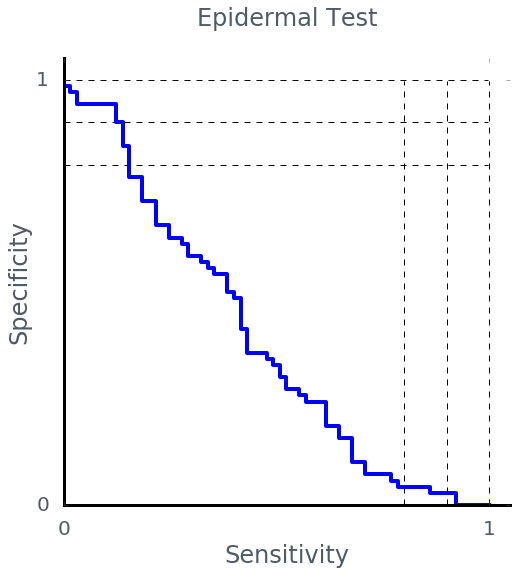

In [18]:
p = probs.copy()
p = p[:, 4:6]
p /= np.sum(p, axis=1).reshape((-1,1))
p = np.argmax(p, axis=1)
print p

l = np.array(label(data))
print l

print 1.0 * np.sum(p == l) / len(l)

plot_results(data, probs_malignant(probabilities[:, 4:6]), [], 'Epidermal Test')

In [19]:
data_filename = '/media/esteva/ExtraDrive1/ThrunResearch/web/image_classifier/curated_pigmented/dermtest_144_noepic.txt'
data = readfile(data_filename)

checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train'
mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mapping'

mapping = ['__unused_background_class__ __unused_background_class']
_mapping = readfile(mapping_file)
mapping.extend(_mapping)

num_classes = 759 + 1 # background class is 0

probabilities = extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes)
# probabilities = keep_epidermal_probabilities(probabilities)
print probabilities.shape
print np.argmax(probabilities, axis=1)

probs = probabilities.copy()
probs = cu.mergeProbabilities(probs, mapping)

print probs.shape
print np.argmax(probs, axis=1)

Succesfully loaded model from model.ckpt-110000 at step=110000.
Extracting 130 / 130 (130, 760)
[724 724 724 717 724 724 754 724 724 724 724 724 724 724 724 712 114 724
 717 108 724 714  47 724 720 724 717 724 724 724 717 724 724 724 724 720
 724 717 724 712 720 714 724 720 754 724 724 724 754 754 712 754 754 724
 754 754 108 754 754 754 754 754 754 754 754 724 724 724 717 724 724 754
 724 724 724 724 724 724 724 724 712 114 724 717 108 724 714  47 724 720
 724 717 724 724 724 717 724 724 724 724 720 724 717 724 712 720 714 724
 720 754 724 724 724 754 754 712 754 754 724 754 754 108 754 754 754 754
 754 754 754 754]
(130, 10)
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 2 8 8 8 9 9 8 9 9 8 9 9 4 9 2 9 9 9 9 9 9 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 4 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8
 8 8 9 9 8 9 9 8 9 9 4 9 2 9 9 9 9 9 9]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.746153846154
Best sens 0.818181818182
Best spec 0.288659793814
Best thresh 8.23932132334e-05
The AUC is 0.52936582318


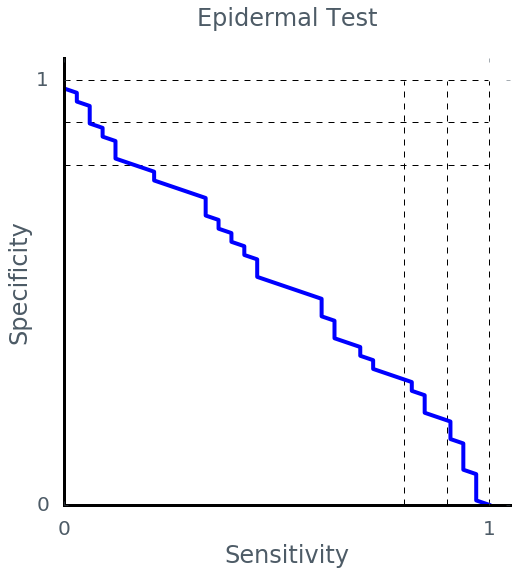

In [20]:
p = probs.copy()
p = p[:, 8:10]
p /= np.sum(p, axis=1).reshape((-1,1))
p = np.argmax(p, axis=1)
print p

l = np.array(label(data))
print l

print 1.0 * np.sum(p == l) / len(l)

plot_results(data, probs_malignant(probabilities[:, 8:10]), [], 'Epidermal Test')

In [22]:
data_filename = '/media/esteva/ExtraDrive1/ThrunResearch/web/image_classifier/curated_dermoscopy/tmp2.txt'
data = readfile(data_filename)

checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train'
mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mapping'

mapping = ['__unused_background_class__ __unused_background_class']
_mapping = readfile(mapping_file)
mapping.extend(_mapping)

num_classes = 759 + 1 # background class is 0

probabilities = extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes)
# probabilities = keep_epidermal_probabilities(probabilities)
print probabilities.shape
print np.argmax(probabilities, axis=1)

probs = probabilities.copy()
probs = cu.mergeProbabilities(probs, mapping)

print probs.shape
print np.argmax(probs, axis=1)

 Succesfully loaded model from model.ckpt-110000 at step=110000.
Extracting 83 / 83 (83, 760)
[717 717 748 717 748 748 717 748 748 717 717 717 748 748 748 748 717 748
 748 748 748 717 748 717 748 748 748 717 748 748 717 717 717 748 717 748
 717 717 717 717 748 748 717 717 717 717 717 717 717 717 717 717 717 748
 748 748 748 717 748 748 748 748 748 748 748 717 748 748 748 748 748 717
 717 717 748 748 748 717 748 748 748 717 748]
(83, 10)
[8 8 9 8 9 9 8 9 9 8 8 8 9 9 9 9 8 9 9 9 9 8 9 8 9 9 9 8 9 9 8 8 8 9 8 9 8
 8 8 8 9 9 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 8 9 9 9 9 9 9 9 8 9 9 9 9 9 8 8 8
 9 9 9 8 9 9 9 8 9]


[0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0
 1 1 1 0 1 1 1 0 1]
[1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0
 0 0 1 0 1 0 0 1 1]
0.493975903614
Best sens 1.0
Best spec 0.0857142857143
Best thresh 2.82363635051e-05
The AUC is 0.484523809524


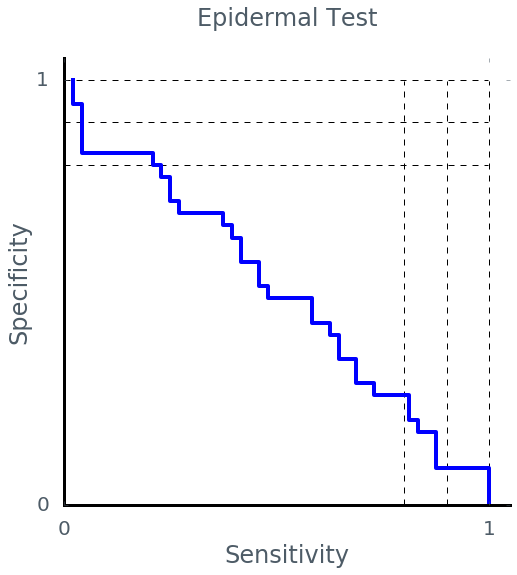

In [23]:
p = probs.copy()
p = p[:, 8:10]
p /= np.sum(p, axis=1).reshape((-1,1))
p = np.argmax(p, axis=1)
print p

l = np.array(label(data))
print l

print 1.0 * np.sum(p == l) / len(l)

plot_results(data, probs_malignant(probabilities[:, 8:10]), [], 'Epidermal Test')

 # Entire Validation Set

In [72]:
data_filename = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/test_sets/validation_set.txt'
data = readfile(data_filename)

checkpoint_dir = '/media/esteva/ExtraDrive1/ThrunResearch/tf_experiments/recursive_dividing_N=1000/train'
mapping_file = '/media/esteva/ExtraDrive1/ThrunResearch/data/skindata4/splits/recursive_dividing_N=1000/labels.txt.mapping'

mapping = ['__unused_background_class__ __unused_background_class']
_mapping = readfile(mapping_file)
mapping.extend(_mapping)

num_classes = 759 + 1 # background class is 0

probabilities = extract_softmax_probabilities(data_filename, checkpoint_dir, num_classes)
print probabilities.shape



Succesfully loaded model from model.ckpt-110000 at step=110000.
Extracting 14709 / 14709, /media/esteva/ExtraDrive1/ThrunResearch/SKIN-9/experiments/skindata3/connected_components/treelearning/recursive_dividing/N=1000/curated_testset/8/httpwwwdermatlasnetimages400ABCD3jpg.jpg (14709, 760)


In [73]:
probs = probabilities.copy()
probs = cu.mergeProbabilities(probs, mapping)

preds = np.argmax(probs, axis=1)
truths = np.array([int(d.split()[1]) for d in data]) + 1

correct_per_class = np.zeros(10, dtype=int)
count_per_class = np.zeros(10, dtype=int)

for p,t in zip(preds, truths):
    count_per_class[t] += 1
    if p == t:
        correct_per_class[t] += 1
print 'Correct:', correct_per_class
print 'Counts:', count_per_class

acc_per_class = 1.0 * correct_per_class / count_per_class
acc_per_class = acc_per_class[1:]
print 'Accuracies:', acc_per_class
print 'Averaage Accuracy: %0.2f' % np.mean(acc_per_class)

Correct: [   0    0   44    0   13  297    3 7045   71   50]
Counts: [    0   117   858    76   635  1446   366 10666   375   170]
Accuracies: [ 0.          0.05128205  0.          0.02047244  0.20539419  0.00819672
  0.66051003  0.18933333  0.29411765]
Averaage Accuracy: 0.16
